# Quality control

Manual thresholds for cell exclusion are applied using the scanpy framework.

# 0. Loading the libraries

In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb

import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [3]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.1.0
anndata2ri                  1.0.6
appdirs                     1.4.4
asttokens                   NA
attr                        21.4.0
backcall                    0.2.0
backports                   NA
beta_ufunc                  NA
binom_ufunc                 NA
bioinfokit                  2.0.8
bioservices                 1.8.4
boto3                       1.23.1
botocore                    1.26.1
brotli                      1.0.9
bs4                         4.11.1
cattr                       NA
certifi                     2021.10.08
cffi                        1.15.0
charset_normalizer          2.0.12
cloudpickle                 2.0.0
colorama                    0.4.4
colorlog                    NA
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.2
dask                        2022.05.0
dateutil                    2.8.2
debugpy                     1.6.0
deco

In [5]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 108))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,35))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# 1. Reading in the data

[Timing: 35s reading from cache]

In [7]:
# Set up data loading
folder_path = "../data/BL_new/"
sample_strings = ['NAIVE_0h-1','NAIVE_0h-2','DMSO_2h','DMSO_24h','DMSO_48h','DMSO_d7','N6_2h','N6_24h','N6_48h','N6_d7']
file_base = "/counts_filtered/"
file_h5ad = "adata.h5ad"
save_folder = "figures/"
sc.settings.figdir = './'+save_folder

In [8]:
# Data set load & annotation
def open_sample(name):

    #Parse Filenames
    filepath = folder_path+name+file_base+file_h5ad
    #Load data
    adata = sc.read(filepath)

    #Annotate data
    adata.obs['sample'] = [name]*adata.n_obs
    adata.obs['cond'] = [name.split("_")[0]]*adata.n_obs
    adata.obs['tp'] = [(name.split("-")[0]).split("_")[1]]*adata.n_obs

    return adata

In [9]:
# Load the first data set
adata = open_sample(sample_strings[0])

# Loop to load the rest of data sets
for i in range(1, len(sample_strings)):

    # Load the following data set
    adata_tmp = open_sample(sample_strings[i])

    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample_id')
    
    adata.obs.drop(columns=['sample_id'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')

In [10]:
seen = set()
unique_genes = []

for item in adata.var["gene_name"]:
    fudge = 1
    newitem = item

    while newitem in seen:
        fudge += 1
        newitem = "{}_{}".format(item, fudge)

    unique_genes.append(newitem)
    seen.add(newitem)

adata.var["unique_genes"] = unique_genes
adata.var = adata.var.set_index("unique_genes")

In [11]:
txt = '*--- Initial cell counts (before pre-processing) ---*\n\n'

# Annotate the data sets
txt += str(adata.obs['cond'].value_counts()) + '\n\n'
txt += str(adata.obs['tp'].value_counts()) + '\n\n'
txt += str(adata.obs['sample'].value_counts()) + '\n\n'

# Checking the total size of the data set
txt += 'We have {:d} cells and {:d} genes in the dataset.'.format(adata.shape[0], adata.shape[1])

print(txt)

# Save to .txt
with open(save_folder+'/initial_cell_counts.txt', 'w') as f:
    f.write(txt)
    f.close()

*--- Initial cell counts (before pre-processing) ---*

DMSO     70058
N6       24867
NAIVE     9260
Name: cond, dtype: int64

48h    64128
d7     12170
24h     9888
0h      9260
2h      8739
Name: tp, dtype: int64

DMSO_48h      56332
N6_d7          8367
N6_48h         7796
NAIVE_0h-2     5932
DMSO_2h        5284
N6_24h         5249
DMSO_24h       4639
DMSO_d7        3803
N6_2h          3455
NAIVE_0h-1     3328
Name: sample, dtype: int64

We have 104185 cells and 55421 genes in the dataset.


In [12]:
adata.X = adata.X.toarray()
adata.layers["ambiguous"] = sp.sparse.csr_matrix(np.zeros(adata.X.shape))
adata.obs["CellID"] = adata.obs.index
adata.var["Accession"] = adata.var.index

In [14]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=sample_strings,ordered=True)
new_obs = adata.obs['sample'].astype(cat_type)
adata.obs['sample'] = new_obs

# 2 Quality control

In [15]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
adata.obs['log_genes'] = np.log10(adata.obs['n_genes'])

# Mito %
mt_gene_mask = [gene.startswith('mt-') for gene in adata.var['gene_name']]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

# Ribo proteins
ribo_prot_mask = [gene.startswith(('Rps', "Rpl")) for gene in adata.var['gene_name']]
adata.obs['ribo_prot'] = adata.X[:, ribo_prot_mask].sum(1)/adata.obs['n_counts']

Pre-filter DMSO_48h

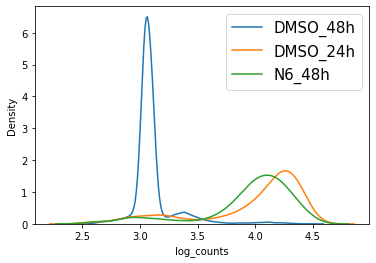

In [16]:
#Thresholding decision: counts
p = sb.kdeplot(adata[adata.obs['sample']=="DMSO_48h"].obs['log_counts'][(adata.obs['n_counts']<40000) & (adata.obs['n_counts']>300)], label='DMSO_48h')
p = sb.kdeplot(adata[adata.obs['sample']=="DMSO_24h"].obs['log_counts'][(adata.obs['n_counts']<40000) & (adata.obs['n_counts']>300)], label='DMSO_24h')
p = sb.kdeplot(adata[adata.obs['sample']=="N6_48h"].obs['log_counts'][(adata.obs['n_counts']<40000) & (adata.obs['n_counts']>300)], label='N6_48h')
plt.legend(prop={'size': 15})
plt.show()
p.figure.savefig(save_folder+"kde_log_counts_DMSO48h.png")

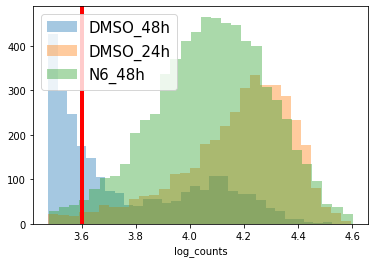

In [17]:
#Thresholding decision: counts
p = sb.distplot(adata[adata.obs['sample']=="DMSO_48h"].obs['log_counts'][(adata.obs['n_counts']<40000) & (adata.obs['n_counts']>3000)], kde=False, hist=True, bins = 30, label='DMSO_48h')
p = sb.distplot(adata[adata.obs['sample']=="DMSO_24h"].obs['log_counts'][(adata.obs['n_counts']<40000) & (adata.obs['n_counts']>3000)], kde=False, hist=True, bins = 30, label='DMSO_24h')
p = sb.distplot(adata[adata.obs['sample']=="N6_48h"].obs['log_counts'][(adata.obs['n_counts']<40000) & (adata.obs['n_counts']>3000)], kde=False, hist=True, bins = 30, label='N6_48h')
p.axvline(3.6, color='red', lw=4)
plt.legend(prop={'size': 15})
plt.show()
p.figure.savefig(save_folder+"hist_log_counts_DMSO48h.png")

In [18]:
adata_dmso = adata[adata.obs['sample'] == "DMSO_48h"].copy()
sc.pp.pca(adata_dmso, n_comps=20, use_highly_variable=False, svd_solver='arpack')

computing PCA
    with n_comps=20
    finished (0:00:58)


computing neighbors
    using 'X_pca' with n_pcs = 20


2022-05-29 17:09:46.312202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/lib/R/lib:/opt/R/lib/R/lib:
2022-05-29 17:09:46.312308: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:49)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:13)


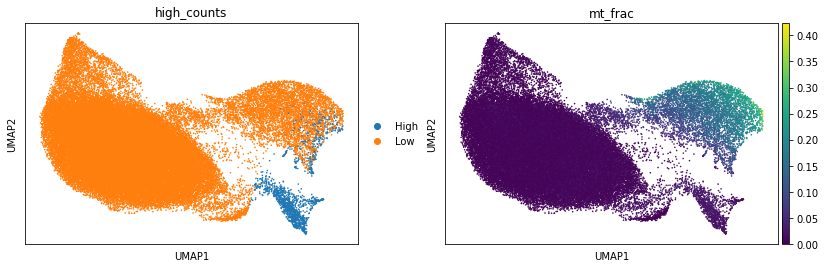

In [19]:
sc.pp.neighbors(adata_dmso)
sc.tl.umap(adata_dmso, random_state=0)

adata_dmso.obs['high_counts'] = ["High" if e > 3.6 else "Low" for e in adata_dmso.obs['log_counts']]
sc.pl.umap(adata_dmso, color=['high_counts', 'mt_frac'], size = 10, save = "_DMSO-48h_highcounts_mtfrac.png")

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:17)


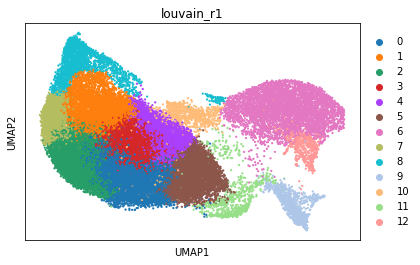

0     10066
1      7900
2      7310
3      7154
4      5686
5      5519
6      4739
7      2579
8      1963
9      1029
10      983
11      839
12      565
Name: louvain_r1, dtype: int64


In [20]:
# Clustering

# Perform clustering - using highly variable genes
sc.tl.louvain(adata_dmso, resolution=1, key_added='louvain_r1', random_state=0)
sc.pl.umap(adata_dmso, color=['louvain_r1'], size = 20, save = "DMSO-48h_clusters.png")
print(adata_dmso.obs['louvain_r1'].value_counts())

In [21]:
adata_dmso = adata_dmso[adata_dmso.obs['louvain_r1'].isin(['6', '9', '10', '11'])]
adata = adata[(adata.obs_names.isin(adata_dmso.obs_names)) | (adata.obs['sample'] != 'DMSO_48h')]
adata.obs['sample'].value_counts()

N6_d7         8367
N6_48h        7796
DMSO_48h      7590
NAIVE_0h-2    5932
DMSO_2h       5284
N6_24h        5249
DMSO_24h      4639
DMSO_d7       3803
N6_2h         3455
NAIVE_0h-1    3328
Name: sample, dtype: int64

In [22]:
adata.obs['sample'].cat.categories

Index(['NAIVE_0h-1', 'NAIVE_0h-2', 'DMSO_2h', 'DMSO_24h', 'DMSO_48h',
       'DMSO_d7', 'N6_2h', 'N6_24h', 'N6_48h', 'N6_d7'],
      dtype='object')

In [23]:
thresholds = [
    [[2000, 8000], [900, 3000], 6],
    [[2000, 9000], [900, 3000], 4],
    [[2000, 10000], [1000, 3000], 5],
    [[6000, 30000], [2000, 5000], 3],
    [[6000, 20000], [1500, 4300], 5],
    [[4000, 30000], [1300, 6000], 7],
    [[2300, 10000], [900, 3000], 4],
    [[2300, 33000], [1300, 5300], 3],
    [[4000, 30000], [1300, 5300], 4],
    [[2300, 10000], [800, 4000], 5],
]

NAIVE_0h-1
NAIVE_0h-2
DMSO_2h
DMSO_24h
DMSO_48h
DMSO_d7
N6_2h
N6_24h
N6_48h
N6_d7


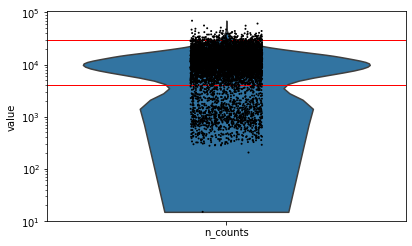

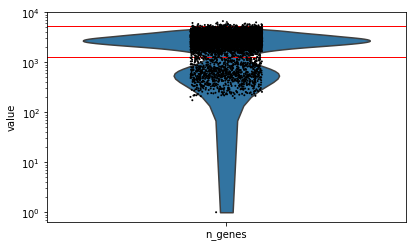

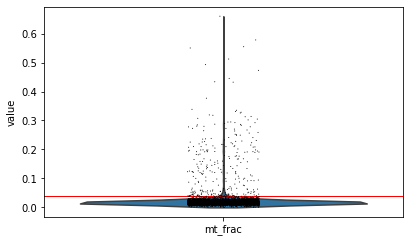

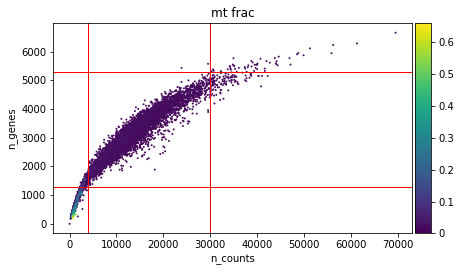

In [24]:
# Quality control - plot QC metrics
samples = adata.obs['sample'].cat.categories
for i in range(len(samples)):
    print(samples[i])

    # counts and genes plot
    t1 = sc.pl.violin(adata[adata.obs['sample']==samples[i]], 'n_counts', size=2, log=True, cut=0, ax=None, show=False)
    t1.axhline(thresholds[i][0][0], color='red', lw=1)
    t1.axhline(thresholds[i][0][1], color='red', lw=1)
    t2 = sc.pl.violin(adata[adata.obs['sample']==samples[i]], 'n_genes', size=2, log=True, cut=0, ax=None, show=False)
    t2.axhline(thresholds[i][1][0], color='red', lw=1)
    t2.axhline(thresholds[i][1][1], color='red', lw=1)

    # mito plot
    t3 = sc.pl.violin(adata[adata.obs['sample']==samples[i]], 'mt_frac', ax=None, show=False)
    t3.axhline(thresholds[i][2]/100, color='red', lw=1)

    # combined plot
    t5 = sc.pl.scatter(adata[adata.obs['sample']==samples[i]], 'n_counts', 'n_genes', color='mt_frac', ax=None, show=False)
    t5.axvline(thresholds[i][0][0], color='red', lw=1)
    t5.axvline(thresholds[i][0][1], color='red', lw=1)
    t5.axhline(thresholds[i][1][0], color='red', lw=1)
    t5.axhline(thresholds[i][1][1], color='red', lw=1)

    #plt.show()
    t1.figure.savefig(save_folder+samples[i]+"_QC_ncounts.png")
    t2.figure.savefig(save_folder+samples[i]+"_QC_ngenes.png")
    t3.figure.savefig(save_folder+samples[i]+"_QC_mtfrac.png")
    t5.figure.savefig(save_folder+samples[i]+"_QC_combined.png")

    if i != 8:
        plt.close(t1.figure)
        plt.close(t2.figure)
        plt.close(t3.figure)
        plt.close(t5.figure)
    

In [25]:
# Apply thresholds

for i in range(len(samples)):
    adata = adata[(adata.obs['sample'] != samples[i]) | (
        (adata.obs['n_counts'] > thresholds[i][0][0]) & (adata.obs['n_counts'] < thresholds[i][0][1]) & (adata.obs['n_genes'] > thresholds[i][1][0]) & (adata.obs['n_genes'] < thresholds[i][1][1]) & (adata.obs['mt_frac'] < thresholds[i][2]/100)
        )]

In [26]:
txt = '*--- Filtered cell counts (after pre-processing) ---*\n\n'

# Annotate the data sets
txt += str(adata.obs['cond'].value_counts()) + '\n\n'
txt += str(adata.obs['tp'].value_counts()) + '\n\n'
txt += str(adata.obs['sample'].value_counts()) + '\n\n'

# Checking the total size of the data set
txt += 'We have {:d} cells and {:d} genes in the dataset.'.format(adata.shape[0], adata.shape[1])

print(txt)

# Save to .txt
with open(save_folder+'/filtered_cell_counts.txt', 'w') as f:
    f.write(txt)
    f.close()

*--- Filtered cell counts (after pre-processing) ---*

N6       19361
DMSO     11238
NAIVE     6826
Name: cond, dtype: int64

d7     8834
24h    8127
48h    7418
0h     6826
2h     6220
Name: tp, dtype: int64

N6_48h        6492
N6_d7         6124
N6_24h        4653
NAIVE_0h-2    4415
DMSO_2h       4128
DMSO_24h      3474
DMSO_d7       2710
NAIVE_0h-1    2411
N6_2h         2092
DMSO_48h       926
Name: sample, dtype: int64

We have 37425 cells and 55421 genes in the dataset.


In [27]:
adata = adata[:,~adata.var_names.isin(["Gm42418", "AY036118"])]
# Technical issues https://doi.org/10.1242/dev.183855

# Min 50 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=50)

filtered out 40838 genes that are detected in less than 50 cells


In [29]:
save_object(adata, 'saved_objects/adata_raw.pkl')

## 2.3 Normalization

In [7]:
# Load the raw post QC data

with open('saved_objects/adata_raw.pkl', 'rb') as inp:
    adata = pickle.load(inp)

In [42]:
# Preprocess adata

# Save a raw layer
adata.raw = adata

# Logarithmize the data matrix
sc.pp.log1p(adata)

# Compute highly_variable_genes
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)

# Scale the data matrix
sc.pp.scale(adata)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [43]:
save_object(adata, 'saved_objects/adata_norm.pkl')

## 2.4 Merge T0

In [14]:
with open('saved_objects/adata_norm.pkl', 'rb') as inp:
    adata = pickle.load(inp)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:15)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:47)


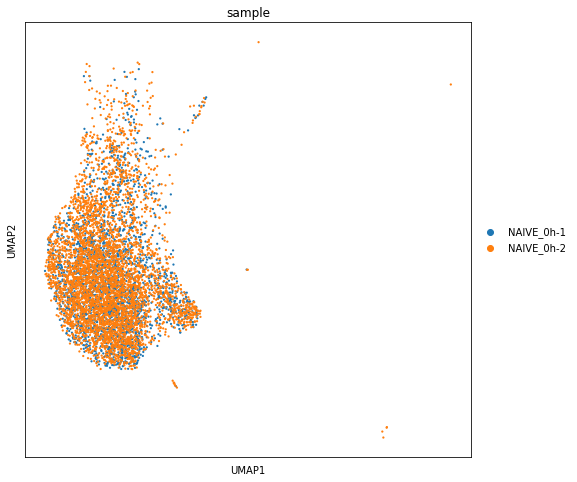

In [45]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata, random_state = 0)
sc.pl.umap(adata[adata.obs['cond'] == 'NAIVE'], color=['sample'], size = 20, save = "_NAIVE_compare.png")

In [46]:
from pandas.api.types import CategoricalDtype
obs_save = adata.obs
dictio = {"NAIVE_0h-1": "NAIVE-0h", "NAIVE_0h-2": "NAIVE-0h", "N6_2h": "N6-2h", "N6_24h": "N6-24h", "N6_48h": "N6-48h", 
          "DMSO_2h": "DMSO-2h", "DMSO_24h": "DMSO-24h", "DMSO_48h": "DMSO-48h",
          "N6_d7": "N6-d7", "DMSO_d7": "DMSO-d7"}
cat_type = CategoricalDtype(categories=["NAIVE-0h", "N6-2h", "DMSO-2h", "N6-24h", "DMSO-24h", "N6-48h", "DMSO-48h", "N6-d7", "DMSO-d7"],ordered=True)
new_obs = obs_save['sample'].map(dictio).astype(cat_type)
adata.obs['sample2'] = new_obs

In [47]:
save_object(adata, 'saved_objects/adata_norm.pkl')

## 2.5 Visualization

In [ ]:
with open('saved_objects/adata_norm.pkl', 'rb') as inp:
    adata = pickle.load(inp)

In [48]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack', random_state = 0)
sc.pp.neighbors(adata, random_state = 0)

sc.tl.tsne(adata, random_state = 0)
sc.tl.umap(adata, random_state = 0)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:03:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:48)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99948996 0.9979419  0.99459654 0.99061424 0.9891457
     0.9885271  0.98645186 0.9800624  0.97891533 0.9769241  0.9746954
     0.9724659  0.9712215  0.9703977 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.u

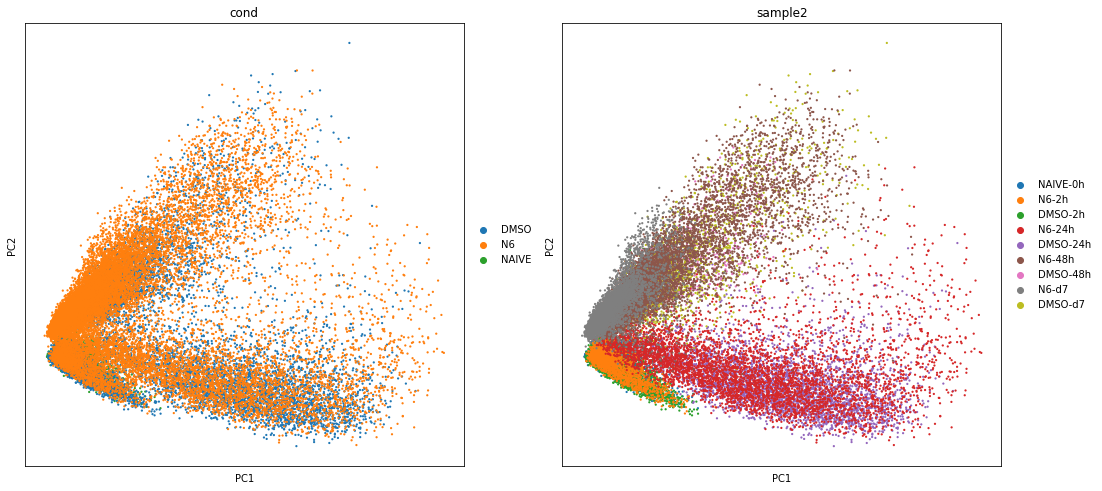

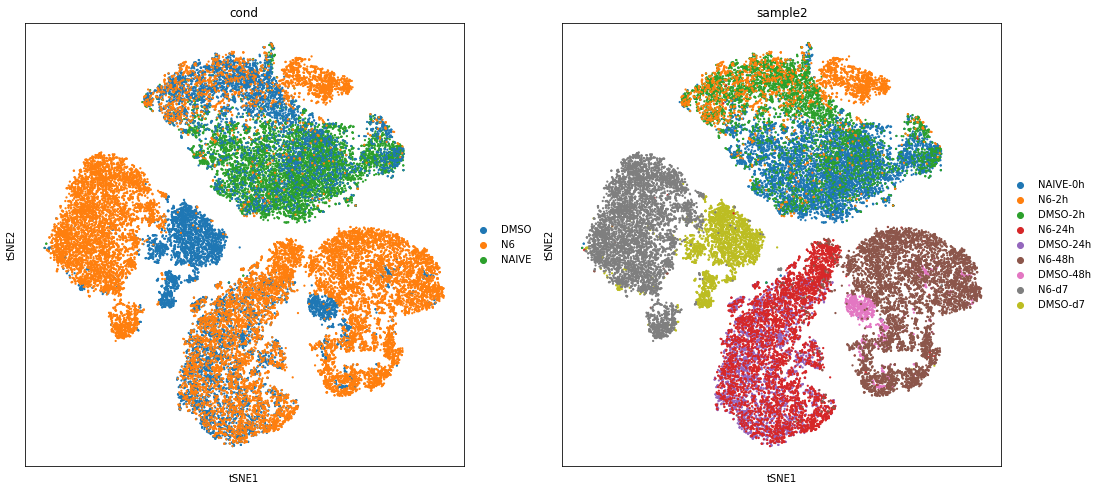

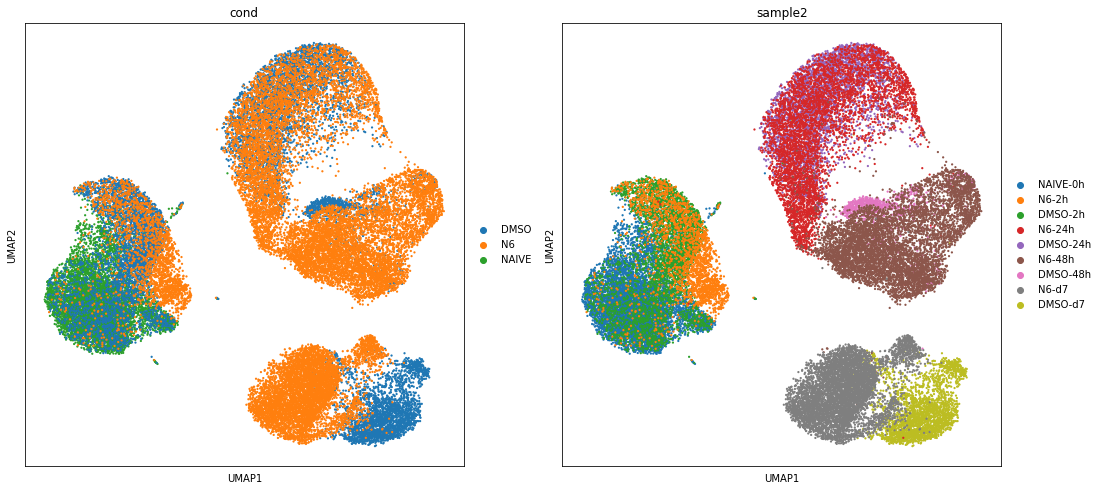

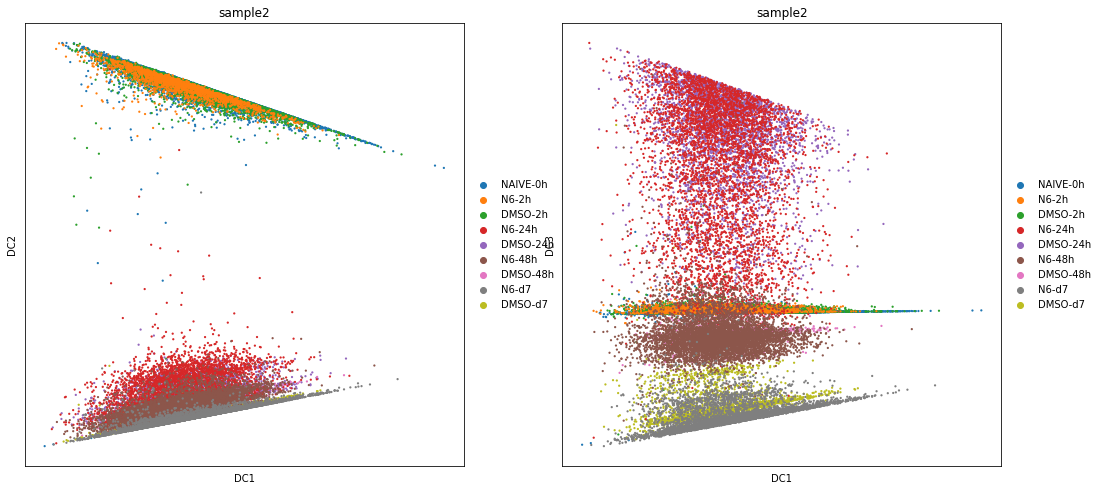

In [49]:
sc.pl.pca_scatter(adata, color=['cond', 'sample2'], size = 20, save = "_pp.png")
sc.pl.tsne(adata, color=['cond', 'sample2'], size = 20, save = "_pp.png")
sc.pl.umap(adata, color=['cond', 'sample2'], size = 20, save = "_pp.png")

In [50]:
save_object(adata, 'saved_objects/adata_viz.pkl')

## 2.6 UMAP Overlaying

In [7]:
with open('saved_objects/adata_viz.pkl', 'rb') as inp:
    adata = pickle.load(inp)

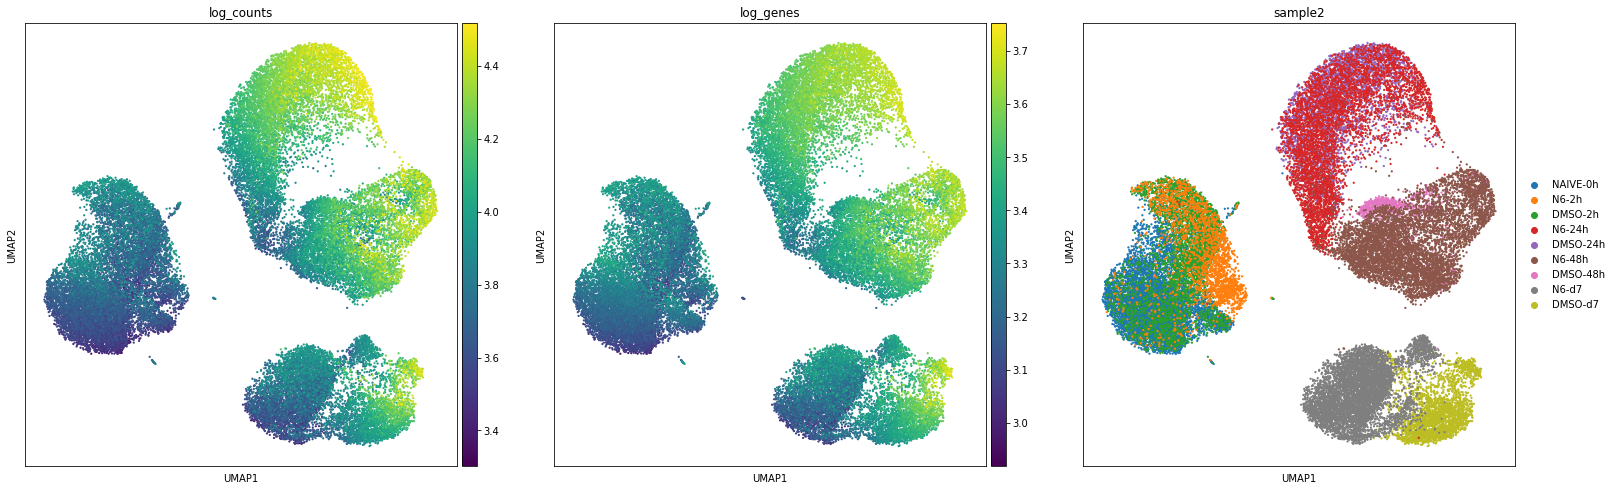

In [65]:
sc.pl.umap(adata, color=['log_counts', 'log_genes', 'sample2'], size = 20, save = "_log_counts.png")

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    2172 total control genes are used. (0:00:14)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    2259 total control genes are used. (0:00:08)
-->     'phase', cell cycle phase (adata.obs)


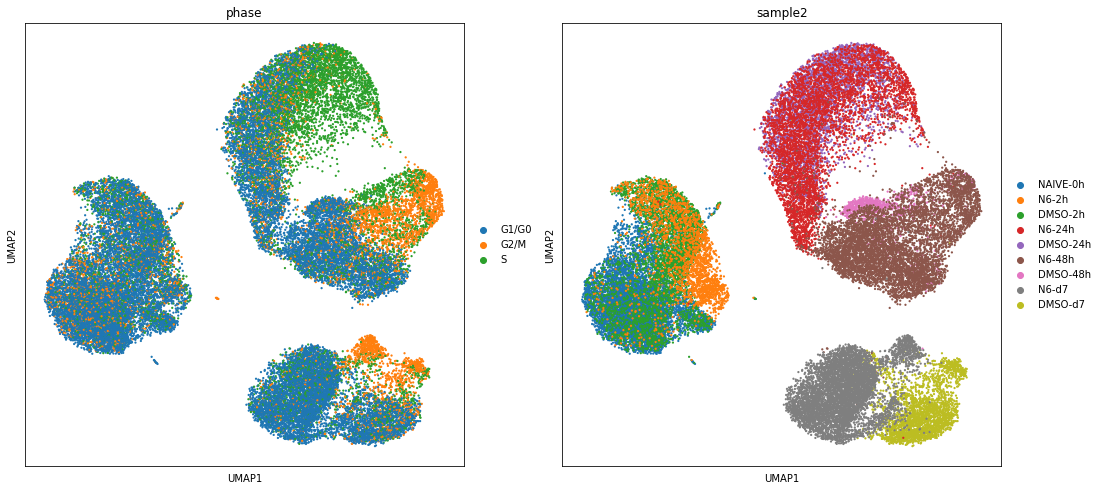

In [8]:
cc_genes_file = 'files/Macosko_cell_cycle_genes.txt'
plt.rcParams['figure.figsize']=(8,8) #rescale figures

#Score cell cycle and visualize the effect:
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_mm = [gene.lower().capitalize() for gene in s_genes]
g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]

s_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, s_genes_mm)]
g2m_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, g2m_genes_mm)]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_mm_ens, g2m_genes=g2m_genes_mm_ens, use_raw = False, random_state = 0)

def rename_phase(e):
    if e == "G1":
        return "G1/G0"
    elif e == "G2M":
        return "G2/M"
    else:
        return e
adata.obs['phase'] = [rename_phase(e) for e in adata.obs['phase']]
sc.pl.umap(adata, color=['phase', 'sample2'], size = 20, save = "_CC_overlay.png")

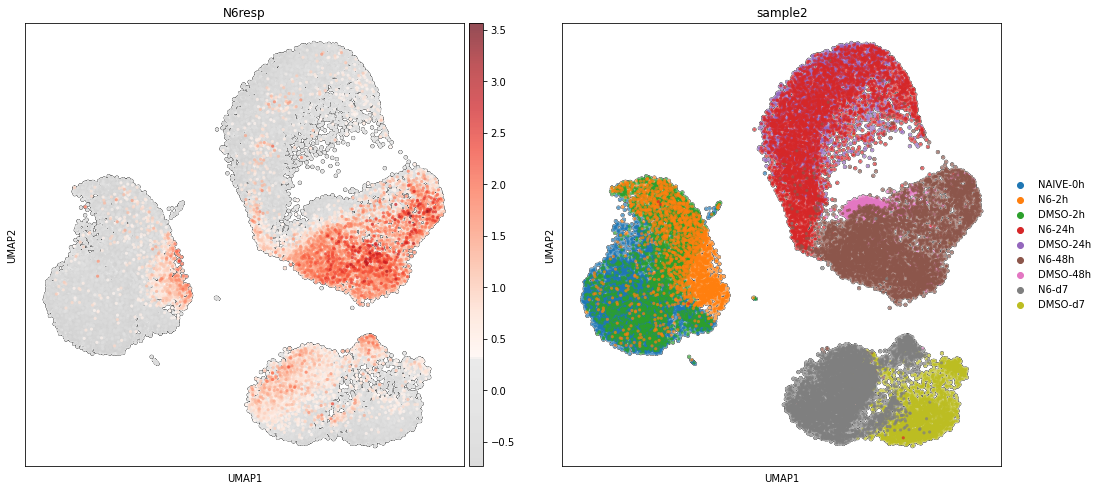

In [66]:
list_markers = ["Hmces", "Net1", "Rgcc", "Saraf", "Nab1", "Ehd4", "Cd81", "Neat1"]
for mark in list_markers:
    adata.obs['N6resp_'+mark] = adata.X[:, adata.var['gene_name'] == mark]
to_show = ['N6resp_'+mark for mark in list_markers]
adata.obs['N6resp'] = adata.obs.loc[:, to_show].mean(axis=1)
sc.pl.umap(adata, cmap = mymap, color = ['N6resp', 'sample2'], size = 40, add_outline = True, outline_width = [0.1, 0.05],
             ncols = 2, save = "_N6resp.png")

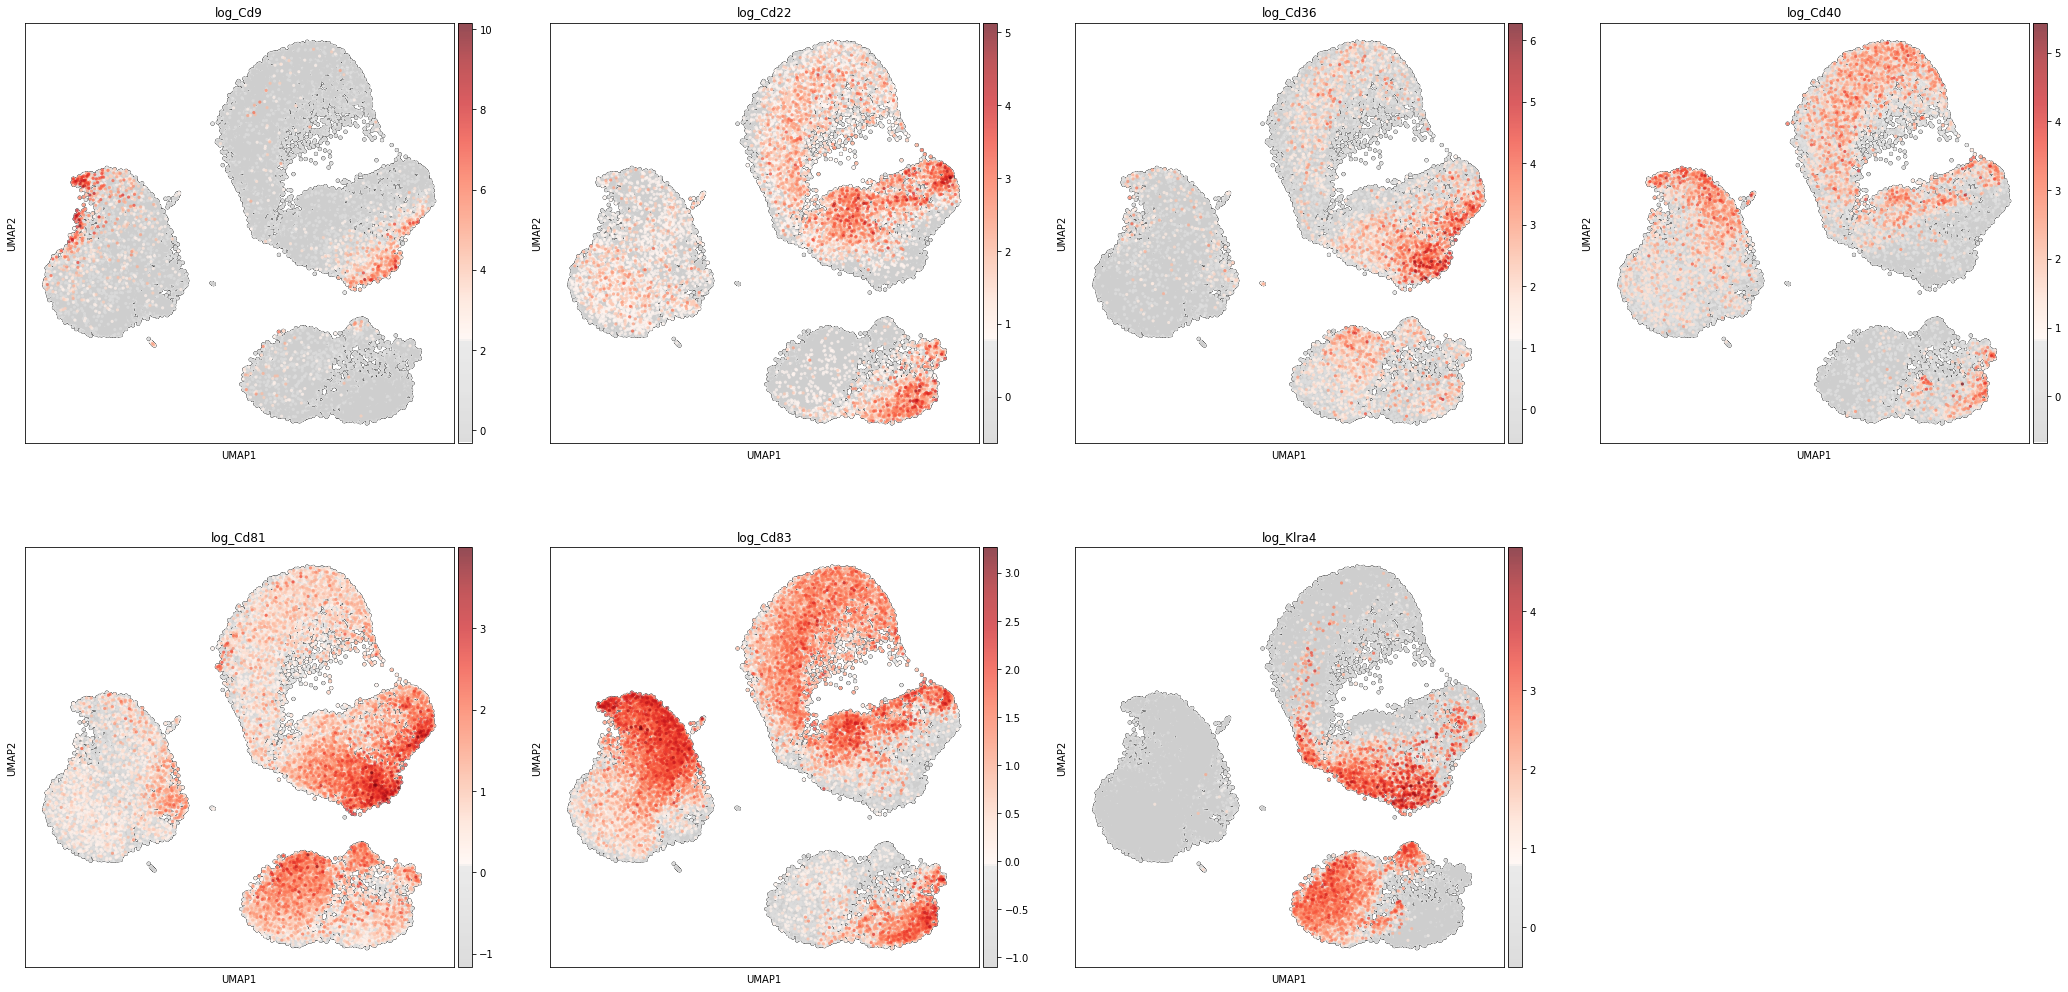

In [67]:
list_markers = ["Cd9", "Cd22", "Cd36", "Cd40", "Cd81", "Cd83", "Klra4"]
for mark in list_markers:
    adata.obs['log_'+mark] = adata.X[:, adata.var['gene_name'] == mark]
to_show = ['log_'+mark for mark in list_markers]
sc.pl.umap(adata, cmap = mymap, color = to_show, size = 40, add_outline = True, outline_width = [0.1, 0.05],
        ncols = 4, save = "_surface1.png")

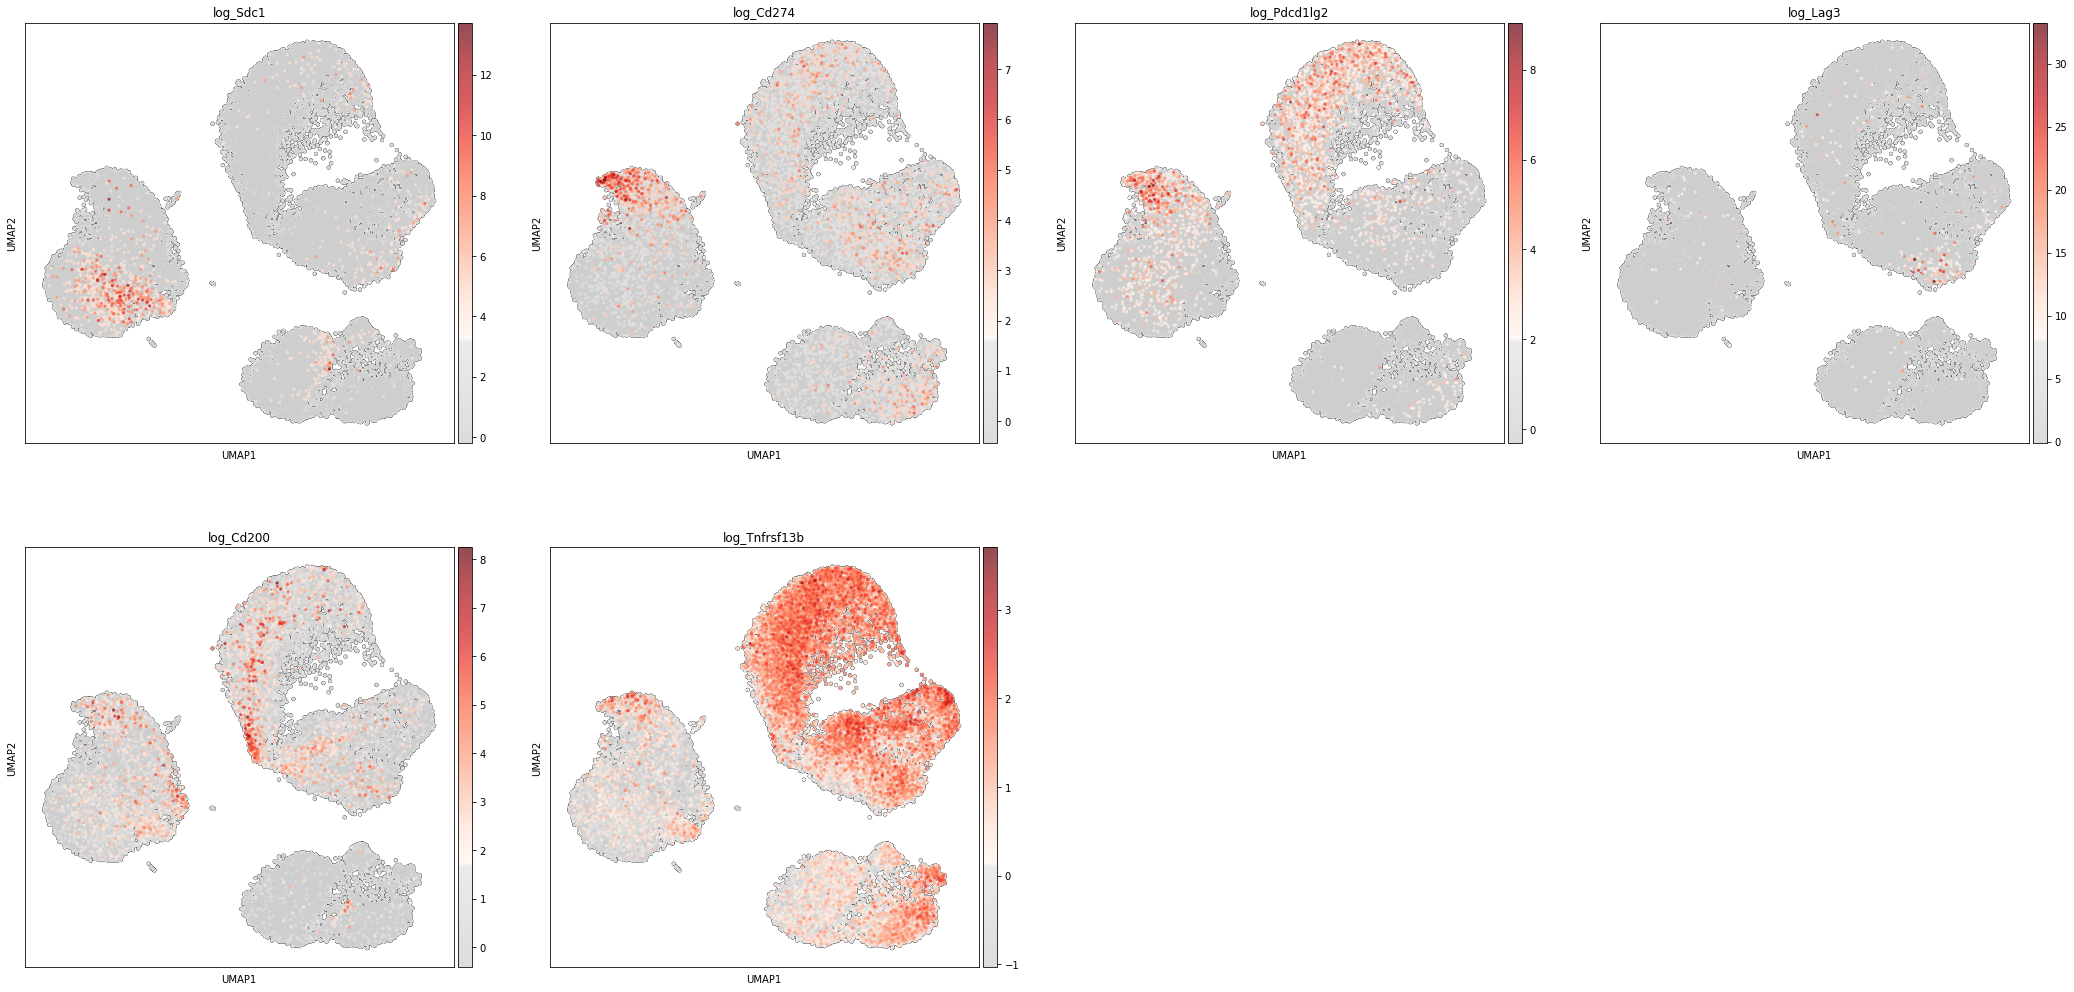

In [68]:
list_markers = ["Sdc1", "Cd274", "Pdcd1lg2", "Lag3", "Cd200", "Tnfrsf13b"]
for mark in list_markers:
    adata.obs['log_'+mark] = adata.X[:, adata.var['gene_name'] == mark]
to_show = ['log_'+mark for mark in list_markers]
sc.pl.umap(adata, cmap = mymap, color = to_show, size = 40, add_outline = True, outline_width = [0.1, 0.05],
        ncols = 4, save = "_surface2.png")

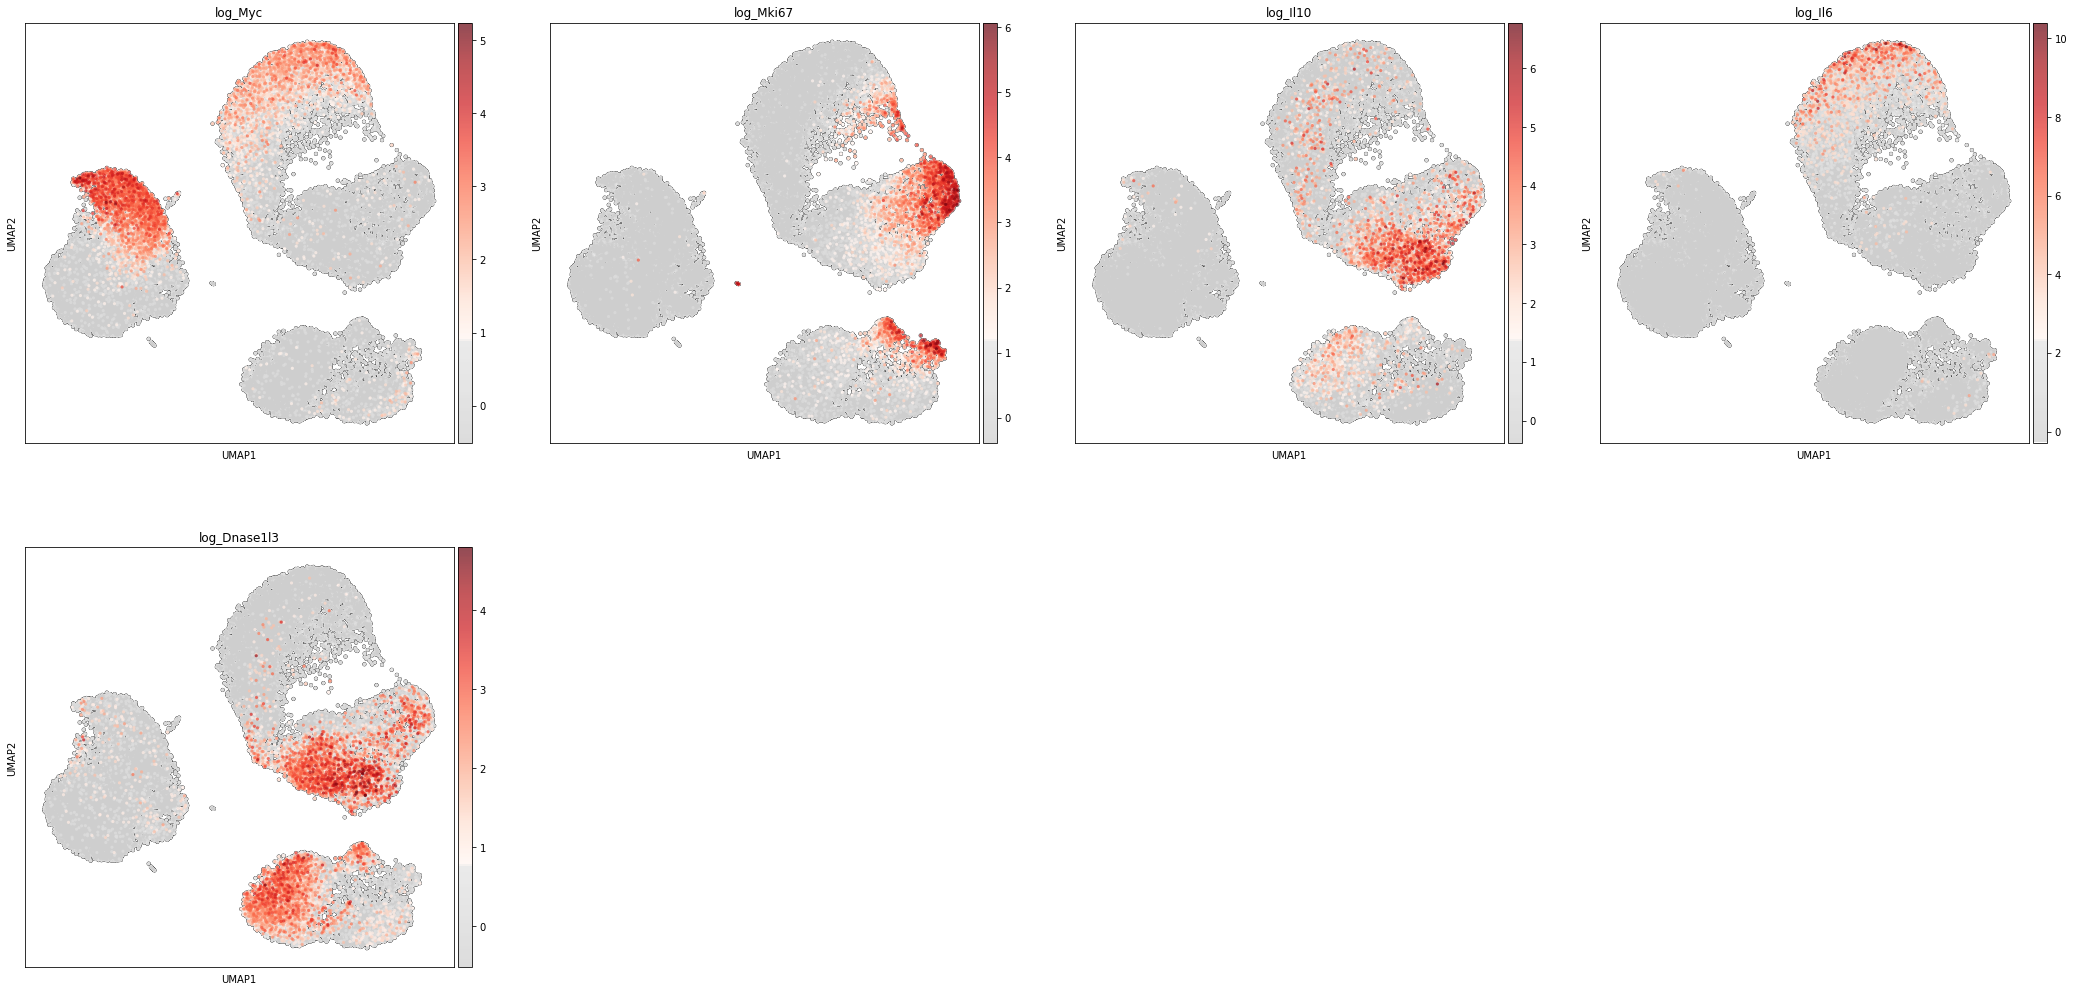

In [69]:
list_markers = ["Myc", "Mki67", "Il10", "Il6", "Dnase1l3"]
for mark in list_markers:
    adata.obs['log_'+mark] = adata.X[:, adata.var['gene_name'] == mark]
to_show = ['log_'+mark for mark in list_markers]
sc.pl.umap(adata, cmap = mymap, color = to_show, size = 40, add_outline = True, outline_width = [0.1, 0.05],
        ncols = 4, save = "_il10_prolif.png")

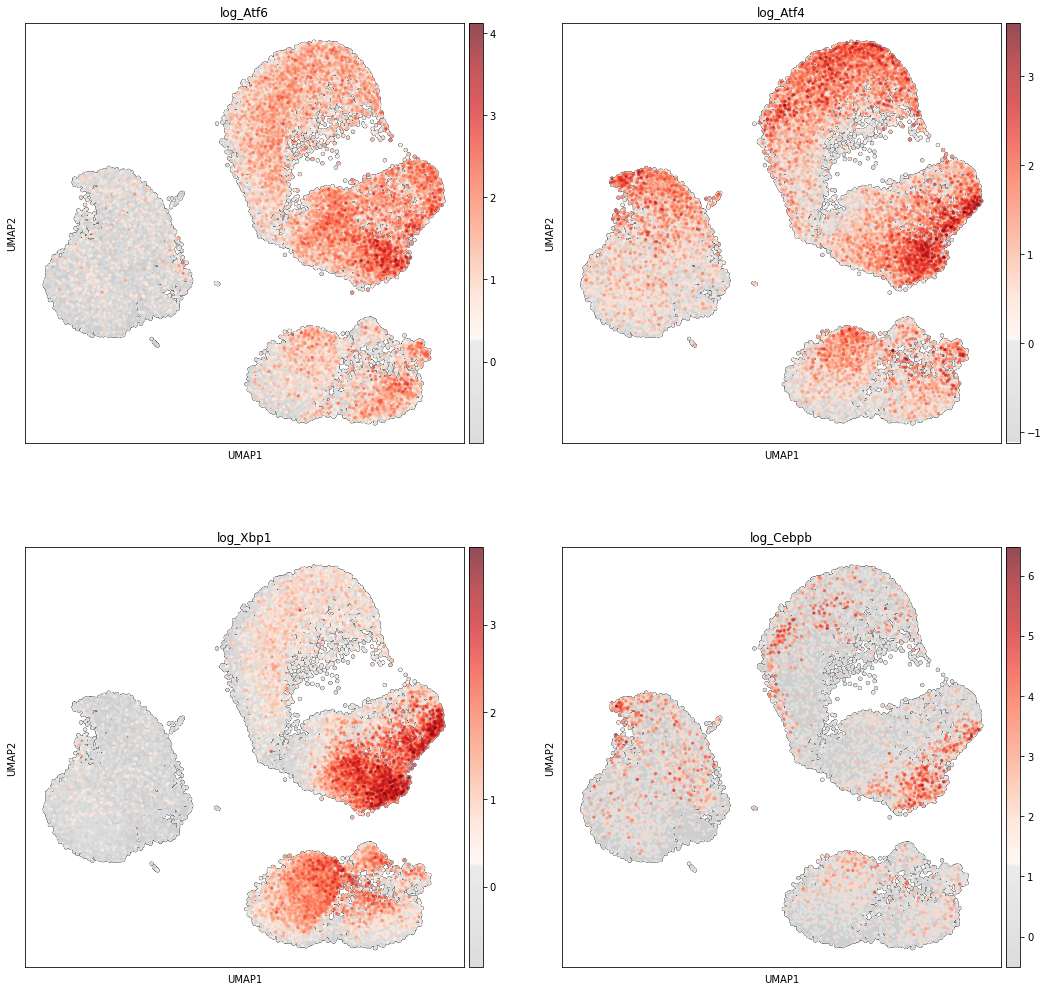

In [70]:
list_markers = ["Atf6", "Atf4", "Xbp1", "Cebpb"]
for mark in list_markers:
    adata.obs['log_'+mark] = adata.X[:, adata.var['gene_name'] == mark]
to_show = ['log_'+mark for mark in list_markers]
sc.pl.umap(adata, cmap = mymap, color = to_show, size = 40, add_outline = True, outline_width = [0.1, 0.05],
        ncols = 2, save = "_upr.png")

## 2.7 PCA/MDS of bulk data

In [17]:
bulkadata = adata.copy()
bulkadata.X = adata.raw.X

In [10]:
# sample
bulk = pd.DataFrame(columns=set(adata.obs['sample']))

for samp in set(adata.obs['sample']):
    bulk[samp] = np.mean(bulkadata.X[adata.obs['sample']==samp,:], axis=0)

samp = bulk.columns
bulk = bulk.T

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardizing the features
bulk = StandardScaler().fit_transform(bulk)

# Compute PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(bulk)
principalDf = pd.DataFrame(data = principalComponents)

In [25]:
names = pd.Series(samp)
finalDf = pd.concat([principalDf, pd.Series(samp)], axis = 1)
pc1 = "PC1 ("+str(round(pca.explained_variance_ratio_[0]*100))+"%)"
pc2 = "PC2 ("+str(round(pca.explained_variance_ratio_[1]*100))+"%)"
finalDf.columns = [pc1, pc2, "samp"]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


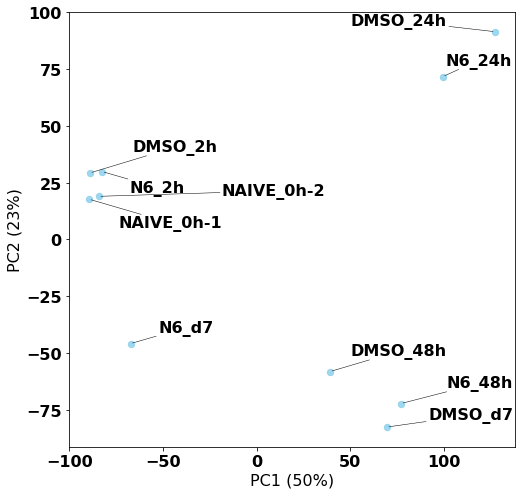

In [38]:
from adjustText import adjust_text

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

# basic plot
sb.regplot(data=finalDf, x=pc1, y=pc2, fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':40})

texts = []
for x, y, s in zip(finalDf[pc1], finalDf[pc2], finalDf.samp):
    texts.append(plt.text(x, y, s))

adjust_text(texts, force_points=0.2, force_text=0.5,
            expand_points=(2, 2), expand_text=(1, 2),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.savefig("figures/PCA_bulk.png", bbox_inches = 'tight')
plt.show()

## 2.8 Pre-processed objects saving

The *adata* object is saved for later

In [ ]:
adata

AnnData object with n_obs × n_vars = 29696 × 13925
    obs: 'sample', 'cond', 'tp', 'CellID', 'n_counts', 'log_counts', 'n_genes', 'log_genes', 'mt_frac', 'ribo_prot', 'sample2', 'S_score', 'G2M_score', 'phase', 'log_il10', 'log_ki67'
    var: 'gene_name', 'Accession', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'tsne', 'diffmap_evals', 'cond_colors', 'sample2_colors', 'phase_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne', 'X_diffmap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'ambiguous'
    obsp: 'distances', 'connectivities'

In [9]:
save_object(adata, 'saved_objects/adata_preprocessed.pkl')